### USX Predictive Maintenance

The business problem for this notebook is about predicting problems caused by component failures such that the question "What is the probability that a machine will fail in the near future due to a failure of a certain component?" can be answered. The problem is formatted as a multi-class classification problem and a machine learning algorithm is used to create the predictive model that learns from historical data collected from machines. 

The following sections go through the steps of implementing such a model which are feature engineering, label construction, training and evaluation.

### Headers

In [44]:
# CSS Files
from IPython.core.display import HTML
from IPython.display import Image

In [45]:
%matplotlib inline

# general libs
import sys
import numpy as np
import pandas as pd
import sklearn
import itertools

#plotting libs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DayLocator, HourLocator, MinuteLocator, AutoDateLocator, DateFormatter

# date time libs
import datetime as dt
from datetime import timedelta
import statsmodels.api as sm 

# ml libs
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas.tools.plotting import scatter_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# CSS Fileb
from IPython.core.display import HTML
from IPython.display import Image

# Style Setting
sns.set(style="ticks", color_codes=True)
sns.set_context("notebook")
sns.set_style("darkgrid")

In [46]:
# Notebook Style Setting
css = open('styles/style-table.css').read() + open('styles/style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [47]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle Code On/Off"></form>''')

### Data Sources

Common data sources for predictive maintenance problems are :
 1. Failure history: The failure history of a node or component within the node. Ex: Alerts
 2. Machine usage. The operating conditions like metric data collected from sensors. Ex: Telemetry
 3. Machine features: The static info of a node. Ex: Config info like num cpus, memory, network etc.
 4. Error Events: The errors in logs but not has tranlated into actual failures. 
 5. Admin Actions: The behaviorial info like API accesses, Jobs run etc.

### Reading Data...

In [48]:
telemetry = pd.read_csv('data/pdm/pdm_telemetry2.csv', index_col=0, parse_dates=True)
errors = pd.read_csv('data/pdm/pdm_errors.csv', index_col=0, parse_dates=True)
ops = pd.read_csv('data/pdm/pdm_ops.csv', index_col=0, parse_dates=True)
alerts = pd.read_csv('data/pdm/pdm_alerts.csv', index_col=0, parse_dates=True)
machines = pd.read_csv('data/pdm/pdm_machines.csv', index_col=0, parse_dates=True)

### Data Cleanup...

#### Processing telemetry data...

The first data source is the telemetry time-series data which consists of metrics m1, m2, m3, m4 etc collected from 100 machines in real time averaged over every hour collected. Below, we display the first 10 records in the dataset. A summary of the whole dataset is also provided.

In [49]:
telemetry = telemetry.dropna()
telemetry['datetime'] = telemetry.index
telemetry.head()

,machineID,m1,m2,m3,m4,datetime
datetime,,,,,,
2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686,2015-01-01 06:00:00
2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973,2015-01-01 07:00:00
2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847,2015-01-01 08:00:00
2015-01-01 09:00:00,1,162.462833,346.149335,109.248561,41.122144,2015-01-01 09:00:00
2015-01-01 10:00:00,1,157.610021,435.376873,111.886648,25.990511,2015-01-01 10:00:00


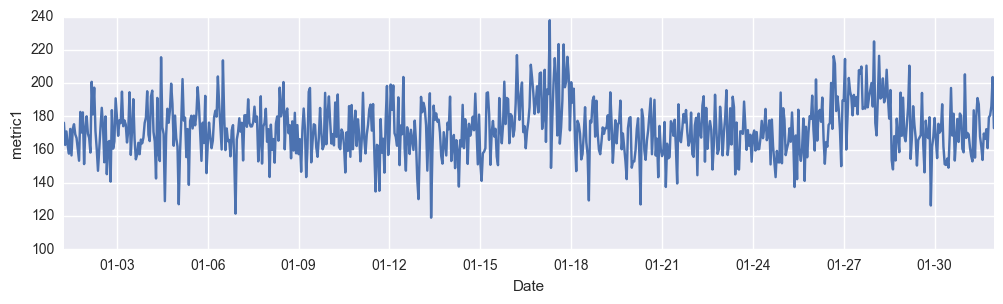

In [50]:
# plot telemetry data
plot_df = telemetry.loc[(telemetry['machineID'] == 1) &
                        (telemetry['datetime'] > pd.to_datetime('2015-01-01')) &
                        (telemetry['datetime'] < pd.to_datetime('2015-02-01')), ['datetime', 'm1']]

sns.set_style("darkgrid")
plt.figure(figsize=(12, 3))
plt.plot(plot_df['datetime'], plot_df['m1'])
plt.ylabel('metric1')

# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
adf.scaled[1.0] = '%m-%d'
plt.xlabel('Date')

#### Processing error data....

The second major data source is the error logs. These are non-breaking errors thrown while the machine is still operational and do not constitute as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

In [51]:
errors = errors.dropna()
errors['datetime'] = errors.index
errors['errorID'] = errors['errorID'].astype('category')

print("Total number of error records: %d" % len(errors.index))
errors.head()

Total number of error records: 3919


,machineID,errorID,datetime
datetime,,,
2015-01-03 07:00:00,1,error1,2015-01-03 07:00:00
2015-01-03 20:00:00,1,error3,2015-01-03 20:00:00
2015-01-04 06:00:00,1,error5,2015-01-04 06:00:00
2015-01-10 15:00:00,1,error4,2015-01-10 15:00:00
2015-01-22 10:00:00,1,error4,2015-01-22 10:00:00


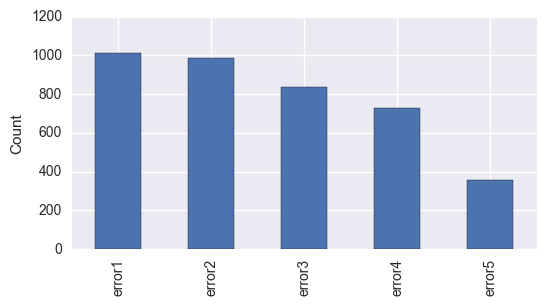

In [52]:
# Plot error data
sns.set_style("darkgrid")
plt.figure(figsize=(6, 3))
errors['errorID'].value_counts().plot(kind='bar')
plt.ylabel('Count')

#### Processing jobs/ops data

These are the scheduled and unscheduled admin operations corresponding to both regular inspection of components as well as failures.

In [53]:
ops = ops.dropna()
ops['datetime'] = ops.index
ops['optype'] = ops['optype'].astype('category')

print("Total number of operation records: %d" % len(ops.index))
ops.head()

Total number of operation records: 3286


,machineID,optype,datetime
datetime,,,
2014-06-01 06:00:00,1,op2,2014-06-01 06:00:00
2014-07-16 06:00:00,1,op4,2014-07-16 06:00:00
2014-07-31 06:00:00,1,op3,2014-07-31 06:00:00
2014-12-13 06:00:00,1,op1,2014-12-13 06:00:00
2015-01-05 06:00:00,1,op4,2015-01-05 06:00:00


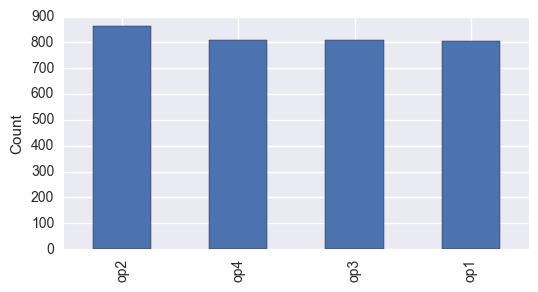

In [54]:
sns.set_style("darkgrid")
plt.figure(figsize=(6, 3))
ops['optype'].value_counts().plot(kind='bar')
plt.ylabel('Count')

#### Processing machines (config) data...

This data set includes some config information about the machines: metrics: cm1, cm2, ....

In [55]:
machines = machines.dropna()
machines['machineID'] = machines.index
machines['model'] = machines['model'].astype('category')
machines.head()

,model,cm1,cm2,machineID
machineID,,,,
1,model3,18,18,1
2,model4,7,7,2
3,model3,8,8,3
4,model3,7,7,4
5,model3,2,2,5


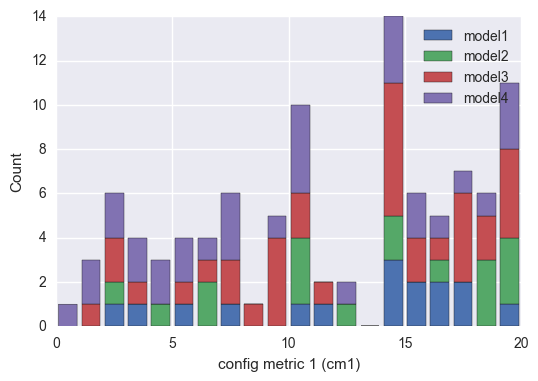

In [56]:
sns.set_style("darkgrid")
plt.figure(figsize=(6, 4))
_, bins, _ = plt.hist([machines.loc[machines['model'] == 'model1', 'cm1'],
                       machines.loc[machines['model'] == 'model2', 'cm1'],
                       machines.loc[machines['model'] == 'model3', 'cm1'],
                       machines.loc[machines['model'] == 'model4', 'cm1']],
                       20, stacked=True, label=['model1', 'model2', 'model3', 'model4'])
plt.xlabel('config metric 1 (cm1)')
plt.ylabel('Count')
plt.legend()

#### Processing alert data...

These are the records of due to failures. Each record has a date and time, machine ID, and alert type.

In [57]:
alerts = alerts.dropna()
alerts['datetime'] = alerts.index
alerts['alerttype'] = alerts['alerttype'].astype('category')

print("Total number of alerts: %d" % len(alerts.index))
alerts.head()

Total number of alerts: 761


,machineID,alerttype,datetime
datetime,,,
2015-01-05 06:00:00,1,alert4,2015-01-05 06:00:00
2015-03-06 06:00:00,1,alert1,2015-03-06 06:00:00
2015-04-20 06:00:00,1,alert2,2015-04-20 06:00:00
2015-06-19 06:00:00,1,alert4,2015-06-19 06:00:00
2015-09-02 06:00:00,1,alert4,2015-09-02 06:00:00


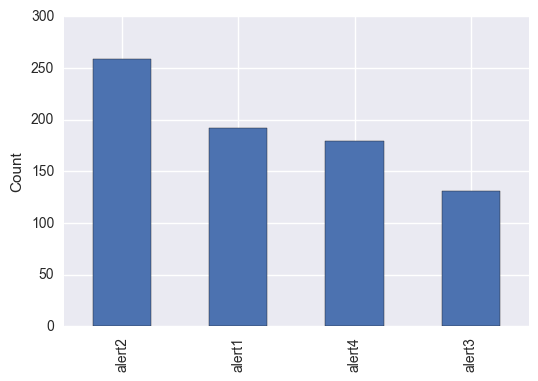

In [58]:
sns.set_style("darkgrid")
plt.figure(figsize=(6, 4))
alerts['alerttype'].value_counts().plot(kind='bar')
plt.ylabel('Count')

### Feature Engineering

The first step in predictive maintenance is feature engineering which requires bringing the different data sources together to create features that best describe a machines's health condition at a given point in time. In the next sections, several feature engineering methods are used to create features based on the properties of each data source.

#### Lag features in telemetry data...

Telemetry data almost always comes with time-stamps which makes it suitable for calculating lagging features. A common method is to pick a window size for the lag features to be created and compute rolling aggregate measures such as mean, standard deviation, minimum, maximum, etc. to represent the short term history of the telemetry over the lag window. In the following, rolling mean and standard deviation of the telemetry data over the last 3 hour lag window is calculated for every 3 hours.

In [59]:
# Capturing 3 hour lag...

# Calculate mean values for telemetry features
temp = []
fields = ['m1', 'm2', 'm3', 'm4']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').mean().unstack())
telemetry_mean_3h = pd.concat(temp, axis=1)
telemetry_mean_3h.columns = [i + 'mean_3h' for i in fields]
telemetry_mean_3h.reset_index(inplace=True)

# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample('3H', closed='left', label='right').std().unstack())
telemetry_sd_3h = pd.concat(temp, axis=1)
telemetry_sd_3h.columns = [i + 'sd_3h' for i in fields]
telemetry_sd_3h.reset_index(inplace=True)

telemetry_mean_3h.head()

,machineID,datetime,m1mean_3h,m2mean_3h,m3mean_3h,m4mean_3h
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542


For capturing a longer term effect, 24 hour lag features are also calculated as below.

In [60]:
# Capturing longer term i.e., 24 hour lag...
temp = []
fields = ['m1', 'm2', 'm3', 'm4']
for col in fields:
    temp.append(pd.rolling_mean(pd.pivot_table(telemetry,
                                               index='datetime',
                                               columns='machineID',
                                               values=col), window=24).resample('3H',
                                                                                closed='left',
                                                                                label='right').first().unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)
telemetry_mean_24h = telemetry_mean_24h.loc[-telemetry_mean_24h['m1mean_24h'].isnull()]

# repeat for standard deviation
temp = []
fields = ['m1', 'm2', 'm3', 'm4']
for col in fields:
    temp.append(pd.rolling_std(pd.pivot_table(telemetry,
                                               index='datetime',
                                               columns='machineID',
                                               values=col), window=24).resample('3H',
                                                                                closed='left',
                                                                                label='right').first().unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h.reset_index(inplace=True)
telemetry_sd_24h = telemetry_sd_24h.loc[-telemetry_sd_24h['m1sd_24h'].isnull()]

# Notice that a 24h rolling average is not available at the earliest timepoints
telemetry_mean_24h.head(10)

C:\Users\durga\Anaconda2\lib\site-packages\ipykernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).mean()
C:\Users\durga\Anaconda2\lib\site-packages\ipykernel\__main__.py:23: FutureWarning: pd.rolling_std is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).std()


,machineID,datetime,m1mean_24h,m2mean_24h,m3mean_24h,m4mean_24h
7,1,2015-01-02 06:00:00,169.733809,445.179865,96.797113,40.385160
8,1,2015-01-02 09:00:00,170.614862,446.364859,96.849785,39.736826
9,1,2015-01-02 12:00:00,169.893965,447.009407,97.715600,39.498374
10,1,2015-01-02 15:00:00,171.243444,444.233563,96.666060,40.229370
11,1,2015-01-02 18:00:00,170.792486,448.440437,95.766838,40.055214
12,1,2015-01-02 21:00:00,170.556674,452.267095,98.065860,40.033247
13,1,2015-01-03 00:00:00,168.460525,451.031783,99.273286,38.903462
14,1,2015-01-03 03:00:00,169.772951,447.502464,99.005946,39.389725
15,1,2015-01-03 06:00:00,170.900562,453.864597,100.877342,38.696225
16,1,2015-01-03 09:00:00,169.533156,454.785072,100.050567,39.449734


Next, the columns of the feature datasets created earlier are merged to create the final feature set from telemetry

In [61]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_3h,
                            telemetry_sd_3h.ix[:, 2:6],
                            telemetry_mean_24h.ix[:, 2:6],
                            telemetry_sd_24h.ix[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

,machineID,m1mean_3h,m2mean_3h,m3mean_3h,m4mean_3h,m1sd_3h,m2sd_3h,m3sd_3h,m4sd_3h,m1mean_24h,m2mean_24h,m3mean_24h,m4mean_24h,m1sd_24h,m2sd_24h,m3sd_24h,m4sd_24h
count,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000
mean,7.149425,170.759835,446.546269,100.718499,40.363512,13.335967,44.458051,8.856354,4.434189,170.762260,446.553506,100.714762,40.363763,14.943508,50.027256,10.005905,4.998746
std,3.837340,9.481885,33.549209,7.283136,3.421159,6.977506,23.159045,4.644075,2.327689,4.674298,18.607756,4.562227,1.968450,2.286384,7.704819,1.674960,0.795468
min,1.000000,134.379553,233.624010,77.174571,28.233622,0.072078,0.078991,0.058744,0.015278,157.487336,282.058246,91.750523,36.117955,6.380619,18.385248,4.782767,2.543443
25%,4.000000,164.465268,427.405897,96.185981,38.163697,8.053800,26.978753,5.344370,2.668832,168.073679,441.639811,98.627703,39.373411,13.361593,44.739781,8.910673,4.458211
50%,7.000000,170.395491,448.544920,100.165179,40.135557,12.493016,41.832189,8.328073,4.156485,170.203366,449.385868,100.066495,40.085562,14.864505,49.794085,9.886470,4.956660
75%,10.000000,176.622180,468.296798,104.252138,42.238844,17.721530,59.026926,11.776862,5.915396,172.432929,456.509521,101.562567,40.830008,16.443465,54.823514,10.940959,5.485687
max,14.000000,221.709795,578.031868,161.983967,65.052523,58.444332,176.159785,33.079288,16.058293,200.496012,492.168696,152.310351,61.314238,27.121504,100.766703,28.654103,9.399470


In [62]:
telemetry_feat.head()

,machineID,datetime,m1mean_3h,m2mean_3h,m3mean_3h,m4mean_3h,m1sd_3h,m2sd_3h,m3sd_3h,m4sd_3h,m1mean_24h,m2mean_24h,m3mean_24h,m4mean_24h,m1sd_24h,m2sd_24h,m3sd_24h,m4sd_24h
7,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,169.733809,445.179865,96.797113,40.385160,11.233120,48.717395,10.079880,5.853209
8,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,170.614862,446.364859,96.849785,39.736826,12.519402,48.385076,10.171540,6.163231
9,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,169.893965,447.009407,97.715600,39.498374,13.370357,42.432317,9.471669,6.195076
10,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,171.243444,444.233563,96.666060,40.229370,13.299281,41.346121,8.731229,5.687944
11,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,170.792486,448.440437,95.766838,40.055214,13.954518,43.490234,8.061653,5.898069


#### Lag features in error data...

Like telemetry data, errors come with timestamps. An important difference is that the error IDs are categorical values and should not be averaged over time intervals like the telemetry measurements. Instead, we count the number of errors of each type in a lagging window. We begin by reformatting the error data to have one entry per machine per time at which at least one error occurred:

In [63]:
errors.head()

,machineID,errorID,datetime
datetime,,,
2015-01-03 07:00:00,1,error1,2015-01-03 07:00:00
2015-01-03 20:00:00,1,error3,2015-01-03 20:00:00
2015-01-04 06:00:00,1,error5,2015-01-04 06:00:00
2015-01-10 15:00:00,1,error4,2015-01-10 15:00:00
2015-01-22 10:00:00,1,error4,2015-01-22 10:00:00


In [64]:
# create a column for each error type
error_count = pd.get_dummies(errors.set_index('datetime')).reset_index()
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']

# combine errors for a given machine in a given hour
error_count_g = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
error_count_g.head(15)

,machineID,datetime,error1,error2,error3,error4,error5
0,1,2015-01-03 07:00:00,1.0,0.0,0.0,0.0,0.0
1,1,2015-01-03 20:00:00,0.0,0.0,1.0,0.0,0.0
2,1,2015-01-04 06:00:00,0.0,0.0,0.0,0.0,1.0
3,1,2015-01-10 15:00:00,0.0,0.0,0.0,1.0,0.0
4,1,2015-01-22 10:00:00,0.0,0.0,0.0,1.0,0.0
5,1,2015-01-25 15:00:00,0.0,0.0,0.0,1.0,0.0
6,1,2015-01-27 04:00:00,1.0,0.0,0.0,0.0,0.0
7,1,2015-03-03 22:00:00,0.0,1.0,0.0,0.0,0.0
8,1,2015-03-05 06:00:00,1.0,0.0,0.0,0.0,0.0
9,1,2015-03-20 18:00:00,1.0,0.0,0.0,0.0,0.0


Now we add blank entries for all other hourly timepoints (since no errors occurred at those times):

In [65]:
error_count = error_count_g.copy()
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()
error_count.head()

,datetime,machineID,error1,error2,error3,error4,error5
0,2015-01-01 06:00:00,1,0.0,0.0,0.0,0.0,0.0
1,2015-01-01 07:00:00,1,0.0,0.0,0.0,0.0,0.0
2,2015-01-01 08:00:00,1,0.0,0.0,0.0,0.0,0.0
3,2015-01-01 09:00:00,1,0.0,0.0,0.0,0.0,0.0
4,2015-01-01 10:00:00,1,0.0,0.0,0.0,0.0,0.0




Now we compute the total number of errors of each type over the last 24 hours, for timepoints taken every three hours:


In [66]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
print(fields)
for col in fields:
    temp.append(pd.rolling_sum(
            pd.pivot_table(error_count, index='datetime', columns='machineID', values=col), 
            window=24).resample('3H', closed='left', label='right', how='first').unstack())
    
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

['error1', 'error2', 'error3', 'error4', 'error5']


C:\Users\durga\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: pd.rolling_sum is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(window=24,center=False).sum()
C:\Users\durga\Anaconda2\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()


,machineID,error1count,error2count,error3count,error4count,error5count
count,38709.000000,38709.000000,38709.000000,38709.000000,38709.000000,38709.000000
mean,7.149552,0.026195,0.028727,0.023173,0.016792,0.007233
std,3.837418,0.161807,0.167812,0.151652,0.128493,0.085047
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,14.000000,2.000000,2.000000,2.000000,1.000000,2.000000


In [67]:
error_count.head()

,machineID,datetime,error1count,error2count,error3count,error4count,error5count
7,1,2015-01-02 06:00:00,0.0,0.0,0.0,0.0,0.0
8,1,2015-01-02 09:00:00,0.0,0.0,0.0,0.0,0.0
9,1,2015-01-02 12:00:00,0.0,0.0,0.0,0.0,0.0
10,1,2015-01-02 15:00:00,0.0,0.0,0.0,0.0,0.0
11,1,2015-01-02 18:00:00,0.0,0.0,0.0,0.0,0.0


#### Lag features in ops data...
Creating lagging features from ops data is not as straightforward as for telemetry and errors, so the features from this data are generated in a more custom way. This type of ad-hoc feature engineering is very common in predictive maintenance since domain knowledge plays a big role in understanding the predictors of a problem. 

In [68]:
# create a column for each op type
ops_rep = pd.get_dummies(ops.set_index('datetime')).reset_index()
ops_rep.columns = ['datetime', 'machineID', 'op1', 'op2', 'op3', 'op4']

# combine operation for a given machine in a given hour
ops_rep = ops_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no operations were done
ops_rep = telemetry[['datetime', 'machineID']].merge(ops_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

ops = ['op1', 'op2', 'op3', 'op4']
for op in ops:
    # convert indicator to most recent date of op 
    ops_rep.loc[ops_rep[op] < 1, op] = None
    ops_rep.loc[-ops_rep[op].isnull(), op] = ops_rep.loc[-ops_rep[op].isnull(), 'datetime']
    
    # forward-fill the most-recent date of op 
    ops_rep[op] = ops_rep[op].fillna(method='ffill')

# remove dates in 2014 (may have NaN or future component change dates)    
ops_rep = ops_rep.loc[ops_rep['datetime'] > pd.to_datetime('2015-01-01')]

# replace dates of most recent ops  with days since most recent op change
for op in ops:
    ops_rep[op] = (ops_rep['datetime'] - ops_rep[op]) / np.timedelta64(1, 'D')
    
ops_rep.describe()

,machineID,op1,op2,op3,op4
count,118261.000000,118261.000000,118261.000000,118261.000000,118261.000000
mean,7.944090,60.601278,50.813081,58.413203,44.579504
std,7.973994,71.938898,66.510489,59.725354,46.855615
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,13.125000,10.625000,14.000000,12.166667
50%,7.000000,34.708333,26.791667,36.375000,29.208333
75%,11.000000,77.791667,59.541667,81.291667,58.916667
max,100.000000,477.000000,339.958333,356.000000,380.000000


In [69]:
ops_rep.head()

,datetime,machineID,op1,op2,op3,op4
0,2015-01-01 06:00:00,1.0,19.000000,214.000000,154.000000,169.000000
1,2015-01-01 07:00:00,1.0,19.041667,214.041667,154.041667,169.041667
2,2015-01-01 08:00:00,1.0,19.083333,214.083333,154.083333,169.083333
3,2015-01-01 09:00:00,1.0,19.125000,214.125000,154.125000,169.125000
4,2015-01-01 10:00:00,1.0,19.166667,214.166667,154.166667,169.166667


#### Machine features

The machine features can be used without further modification. These include descriptive information about the type of each machine and its config metrics.

#### Final merge....
Finally, we merge all the feature data sets we created earlier to get the final feature matrix.

In [70]:
final_feat = telemetry_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(ops_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(machines, on=['machineID'], how='left')
final_feat.describe()

,machineID,m1mean_3h,m2mean_3h,m3mean_3h,m4mean_3h,m1sd_3h,m2sd_3h,m3sd_3h,m4sd_3h,m1mean_24h,...,error2count,error3count,error4count,error5count,op1,op2,op3,op4,cm1,cm2
count,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,...,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.000000,38695.00000,38695.000000,38695.000000
mean,7.149425,170.759835,446.546269,100.718499,40.363512,13.335967,44.458051,8.856354,4.434189,170.762260,...,0.028738,0.023155,0.016798,0.007236,60.726337,50.703285,58.477158,44.45209,9.958444,9.958444
std,3.837340,9.481885,33.549209,7.283136,3.421159,6.977506,23.159045,4.644075,2.327689,4.674298,...,0.167842,0.151597,0.128516,0.085062,72.010193,66.490671,59.619580,46.58045,5.270227,5.270227
min,1.000000,134.379553,233.624010,77.174571,28.233622,0.072078,0.078991,0.058744,0.015278,157.487336,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000
25%,4.000000,164.465268,427.405897,96.185981,38.163697,8.053800,26.978753,5.344370,2.668832,168.073679,...,0.000000,0.000000,0.000000,0.000000,13.125000,10.625000,14.000000,12.12500,7.000000,7.000000
50%,7.000000,170.395491,448.544920,100.165179,40.135557,12.493016,41.832189,8.328073,4.156485,170.203366,...,0.000000,0.000000,0.000000,0.000000,34.875000,26.750000,36.500000,29.12500,8.000000,8.000000
75%,10.000000,176.622180,468.296798,104.252138,42.238844,17.721530,59.026926,11.776862,5.915396,172.432929,...,0.000000,0.000000,0.000000,0.000000,77.875000,59.125000,81.375000,58.62500,15.000000,15.000000
max,14.000000,221.709795,578.031868,161.983967,65.052523,58.444332,176.159785,33.079288,16.058293,200.496012,...,2.000000,2.000000,1.000000,2.000000,382.875000,339.875000,266.875000,258.87500,20.000000,20.000000


In [71]:
final_feat.head()

,machineID,datetime,m1mean_3h,m2mean_3h,m3mean_3h,m4mean_3h,m1sd_3h,m2sd_3h,m3sd_3h,m4sd_3h,...,error3count,error4count,error5count,op1,op2,op3,op4,model,cm1,cm2
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,18
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,18
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,18
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,18
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,18


### Label Construction

When using multi-class classification for predicting failure due to a problem, labelling is done by taking a time window prior to the failure of an asset and labelling the feature records that fall into that window as "about to fail due to a problem" while labelling all other records as "normal." This time window should be picked according to the business case: in some situations it may be enough to predict failures hours in advance, while in others days or weeks may be needed to allow e.g. for arrival of replacement parts.

The prediction problem for this example scenerio is to estimate the probability that a machine will fail in the near future due to a failure of a certain component. More specifically, the goal is to compute the probability that a machine will fail in the next 24 hours due to a certain component failure (component 1, 2, 3, or 4). Below, a categorical failure feature is created to serve as the label. All records within a 24 hour window before a failure of component 1 have failure=comp1, and so on for components 2, 3, and 4; all records not within 24 hours of a component failure have failure=none.


In [72]:
labeled_features = final_feat.merge(alerts, on=['datetime', 'machineID'], how='left')
labeled_features = labeled_features.fillna(method='bfill', limit=7) # fill backward up to 24h
labeled_features = labeled_features.fillna('none')
labeled_features.head()

,machineID,datetime,m1mean_3h,m2mean_3h,m3mean_3h,m4mean_3h,m1sd_3h,m2sd_3h,m3sd_3h,m4sd_3h,...,error4count,error5count,op1,op2,op3,op4,model,cm1,cm2,alerttype
0,1,2015-01-02 06:00:00,180.133784,440.608320,94.137969,41.551544,21.322735,48.770512,2.135684,10.037208,...,0.0,0.0,20.000,215.000,155.000,170.000,model3,18,18,none
1,1,2015-01-02 09:00:00,176.364293,439.349655,101.553209,36.105580,18.952210,51.329636,13.789279,6.737739,...,0.0,0.0,20.125,215.125,155.125,170.125,model3,18,18,none
2,1,2015-01-02 12:00:00,160.384568,424.385316,99.598722,36.094637,13.047080,13.702496,9.988609,1.639962,...,0.0,0.0,20.250,215.250,155.250,170.250,model3,18,18,none
3,1,2015-01-02 15:00:00,170.472461,442.933997,102.380586,40.483002,16.642354,56.290447,3.305739,8.854145,...,0.0,0.0,20.375,215.375,155.375,170.375,model3,18,18,none
4,1,2015-01-02 18:00:00,163.263806,468.937558,102.726648,40.921802,17.424688,38.680380,9.105775,3.060781,...,0.0,0.0,20.500,215.500,155.500,170.500,model3,18,18,none


Below is an example of records that are labeled as failure=comp4 in the failure column. Notice that the first 8 records all occur in the 24-hour window before the first recorded failure of component 4. The next 8 records are within the 24 hour window before another failure of component 4

In [73]:
labeled_features.loc[labeled_features['alerttype'] == 'alert4'][:16]

,machineID,datetime,m1mean_3h,m2mean_3h,m3mean_3h,m4mean_3h,m1sd_3h,m2sd_3h,m3sd_3h,m4sd_3h,...,error4count,error5count,op1,op2,op3,op4,model,cm1,cm2,alerttype
17,1,2015-01-04 09:00:00,166.281848,453.787824,106.187582,51.990080,24.276228,23.621315,11.176731,3.394073,...,0.0,1.0,22.125,217.125,157.125,172.125,model3,18,18,alert4
18,1,2015-01-04 12:00:00,175.412103,445.450581,100.887363,54.251534,34.918687,11.001625,10.580336,2.921501,...,0.0,1.0,22.250,217.250,157.250,172.250,model3,18,18,alert4
19,1,2015-01-04 15:00:00,157.347716,451.882075,101.289380,48.602686,24.617739,28.950883,9.966729,2.356486,...,0.0,1.0,22.375,217.375,157.375,172.375,model3,18,18,alert4
20,1,2015-01-04 18:00:00,176.450550,446.033068,84.521555,47.638836,8.071400,76.511343,2.636879,4.108621,...,0.0,1.0,22.500,217.500,157.500,172.500,model3,18,18,alert4
21,1,2015-01-04 21:00:00,190.325814,422.692565,107.393234,49.552856,8.390777,7.176553,4.262645,7.598552,...,0.0,1.0,22.625,217.625,157.625,172.625,model3,18,18,alert4
22,1,2015-01-05 00:00:00,169.985134,458.929418,91.494362,54.882021,9.451483,12.052752,3.685906,6.621183,...,0.0,1.0,22.750,217.750,157.750,172.750,model3,18,18,alert4
23,1,2015-01-05 03:00:00,149.082619,412.180336,93.509785,54.386079,19.075952,30.715081,3.090266,6.530610,...,0.0,1.0,22.875,217.875,157.875,172.875,model3,18,18,alert4
24,1,2015-01-05 06:00:00,185.782709,439.531288,99.413660,51.558082,14.495664,45.663743,4.289212,7.330397,...,0.0,1.0,0.000,218.000,158.000,0.000,model3,18,18,alert4
1337,1,2015-06-18 09:00:00,169.324639,453.923471,101.313249,53.092274,28.155693,42.557599,7.688674,2.488851,...,0.0,1.0,89.125,29.125,14.125,134.125,model3,18,18,alert4
1338,1,2015-06-18 12:00:00,190.691297,441.577271,97.192512,44.025425,6.296827,47.271008,7.577957,4.648336,...,0.0,1.0,89.250,29.250,14.250,134.250,model3,18,18,alert4


### Modelling


#### Training, Validation and Testing

When working with time-stamped data as in this example, record partitioning into training, validation, and test sets should be performed carefully to prevent overestimating the performance of the models. 

In predictive maintenance, the features are usually generated using lagging aggregates: records in the same time window will likely have identical labels and similar feature values. These correlations can give a model an "unfair advantage" when predicting on a test set record that shares its time window with a training set record. We therefore partition records into training, validation, and test sets in large chunks, to minimize the number of time intervals shared between them.

Predictive models have no advance knowledge of future chronological trends: in practice, such trends are likely to exist and to adversely impact the model's performance. To obtain an accurate assessment of a predictive model's performance, we recommend training on older records and validating/testing using newer records.

For both of these reasons, a time-dependent record splitting strategy is an excellent choice for predictive maintenace models. The split is effected by choosing a point in time based on the desired size of the training and test sets: all records before the timepoint are used for training the model, and all remaining records are used for testing. (If desired, the timeline could be further divided to create validation sets for parameter selection.) To prevent any records in the training set from sharing time windows with the records in the test set, we remove any records at the boundary -- in this case, by ignoring 24 hours' worth of data prior to the timepoint.


In [74]:
# make test and training splits
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

test_results = []
models = []
for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'alerttype']
    train_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime',
                                                                                                        'machineID',
                                                                                                        'alerttype'], 1))
    test_X = pd.get_dummies(labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime',
                                                                                                       'machineID',
                                                                                                       'alerttype'], 1))
    # train and predict using the model, storing results for later
    my_model = GradientBoostingClassifier(random_state=42)
    my_model.fit(train_X, train_y)
    test_result = pd.DataFrame(labeled_features.loc[labeled_features['datetime'] > first_test_date])
    test_result['predicted_failure'] = my_model.predict(test_X)
    test_results.append(test_result)
    models.append(my_model)

we plot the feature importances in the (first) trained model:

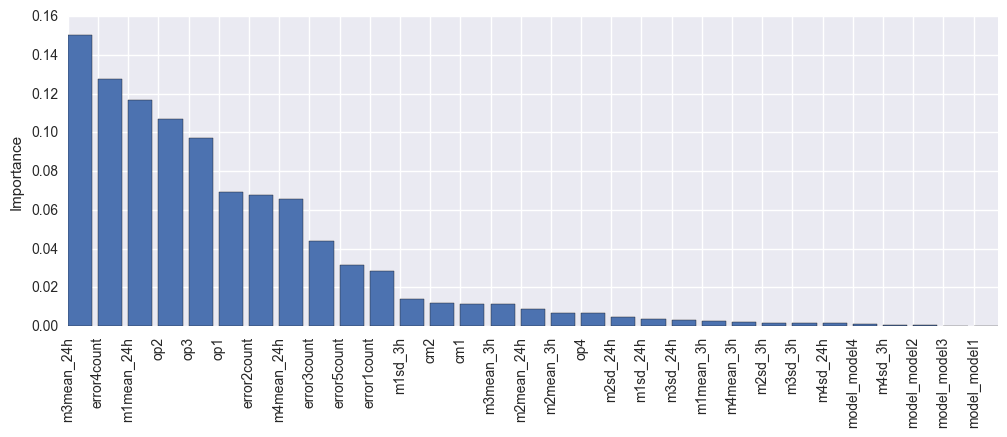

In [75]:
sns.set_style("darkgrid")
plt.figure(figsize=(12, 4))
labels, importances = zip(*sorted(zip(test_X.columns, models[0].feature_importances_), reverse=True, key=lambda x: x[1]))
plt.xticks(range(len(labels)), labels)
_, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.bar(range(len(importances)), importances)
plt.ylabel('Importance')

### Evaluation

In predictive maintenance, machine failures are usually rare occurrences in the lifetime of the assets compared to normal operation. This causes an imbalance in the label distribution which usually causes poor performance as algorithms tend to classify majority class examples better at the expense of minority class examples as the total misclassification error is much improved when majority class is labeled correctly. 

This causes low recall rates although accuracy can be high and becomes a larger problem when the cost of false alarms to the business is very high. To help with this problem, sampling techniques such as oversampling of the minority examples are usually used along with more sophisticated techniques which are not covered in this notebook.

Link: https://github.com/scikit-learn-contrib/imbalanced-learn

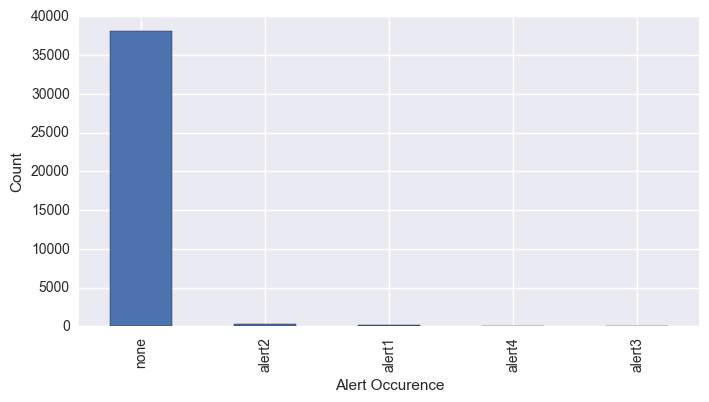

In [76]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
labeled_features['alerttype'].value_counts().plot(kind='bar')
plt.xlabel('Alert Occurence')
plt.ylabel('Count')

Also, due to the class imbalance problem, it is important to look at evaluation metrics other than accuracy alone and compare those metrics to the baseline metrics which are computed when random chance is used to make predictions rather than a machine learning model. The comparison will bring out the value and benefits of using a machine learning model better.

In [77]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

def Evaluate(predicted, actual, labels):
    output_labels = []
    output = []
    
    # Calculate and display confusion matrix
    cm = confusion_matrix(actual, predicted, labels=labels)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)
    
    # Calculate precision, recall, and F1 score
    accuracy = np.array([float(np.trace(cm)) / np.sum(cm)] * len(labels))
    precision = precision_score(actual, predicted, average=None, labels=labels)
    recall = recall_score(actual, predicted, average=None, labels=labels)
    f1 = 2 * precision * recall / (precision + recall)
    output.extend([accuracy.tolist(), precision.tolist(), recall.tolist(), f1.tolist()])
    output_labels.extend(['accuracy', 'precision', 'recall', 'F1'])
    
    # Calculate the macro versions of these metrics
    output.extend([[np.mean(precision)] * len(labels),
                   [np.mean(recall)] * len(labels),
                   [np.mean(f1)] * len(labels)])
    output_labels.extend(['macro precision', 'macro recall', 'macro F1'])
    
    # Find the one-vs.-all confusion matrix
    cm_row_sums = cm.sum(axis = 1)
    cm_col_sums = cm.sum(axis = 0)
    s = np.zeros((2, 2))
    for i in range(len(labels)):
        v = np.array([[cm[i, i],
                       cm_row_sums[i] - cm[i, i]],
                      [cm_col_sums[i] - cm[i, i],
                       np.sum(cm) + cm[i, i] - (cm_row_sums[i] + cm_col_sums[i])]])
        s += v
    s_row_sums = s.sum(axis = 1)
    
    # Add average accuracy and micro-averaged  precision/recall/F1
    avg_accuracy = [np.trace(s) / np.sum(s)] * len(labels)
    micro_prf = [float(s[0,0]) / s_row_sums[0]] * len(labels)
    output.extend([avg_accuracy, micro_prf])
    output_labels.extend(['average accuracy',
                          'micro-averaged precision/recall/F1'])
    
    # Compute metrics for the majority classifier
    mc_index = np.where(cm_row_sums == np.max(cm_row_sums))[0][0]
    cm_row_dist = cm_row_sums / float(np.sum(cm))
    mc_accuracy = 0 * cm_row_dist; mc_accuracy[mc_index] = cm_row_dist[mc_index]
    mc_recall = 0 * cm_row_dist; mc_recall[mc_index] = 1
    mc_precision = 0 * cm_row_dist
    mc_precision[mc_index] = cm_row_dist[mc_index]
    mc_F1 = 0 * cm_row_dist;
    mc_F1[mc_index] = 2 * mc_precision[mc_index] / (mc_precision[mc_index] + 1)
    output.extend([mc_accuracy.tolist(), mc_recall.tolist(),
                   mc_precision.tolist(), mc_F1.tolist()])
    output_labels.extend(['majority class accuracy', 'majority class recall',
                          'majority class precision', 'majority class F1'])
        
    # Random accuracy and kappa
    cm_col_dist = cm_col_sums / float(np.sum(cm))
    exp_accuracy = np.array([np.sum(cm_row_dist * cm_col_dist)] * len(labels))
    kappa = (accuracy - exp_accuracy) / (1 - exp_accuracy)
    output.extend([exp_accuracy.tolist(), kappa.tolist()])
    output_labels.extend(['expected accuracy', 'kappa'])
    

    # Random guess
    rg_accuracy = np.ones(len(labels)) / float(len(labels))
    rg_precision = cm_row_dist
    rg_recall = np.ones(len(labels)) / float(len(labels))
    rg_F1 = 2 * cm_row_dist / (len(labels) * cm_row_dist + 1)
    output.extend([rg_accuracy.tolist(), rg_precision.tolist(),
                   rg_recall.tolist(), rg_F1.tolist()])
    output_labels.extend(['random guess accuracy', 'random guess precision',
                          'random guess recall', 'random guess F1'])
    
    # Random weighted guess
    rwg_accuracy = np.ones(len(labels)) * sum(cm_row_dist**2)
    rwg_precision = cm_row_dist
    rwg_recall = cm_row_dist
    rwg_F1 = cm_row_dist
    output.extend([rwg_accuracy.tolist(), rwg_precision.tolist(),
                   rwg_recall.tolist(), rwg_F1.tolist()])
    output_labels.extend(['random weighted guess accuracy',
                          'random weighted guess precision',
                          'random weighted guess recall',
                          'random weighted guess F1'])

    output_df = pd.DataFrame(output, columns=labels)
    output_df.index = output_labels
                  
    return output_df

In [78]:
evaluation_results = []
for i, test_result in enumerate(test_results):
    print('\nSplit %d:' % (i+1))
    evaluation_result = Evaluate(actual = test_result['alerttype'],
                                 predicted = test_result['predicted_failure'],
                                 labels = ['none', 'alert1', 'alert2', 'alert3', 'alert4'])
    evaluation_results.append(evaluation_result)
    
evaluation_results[0]  # show full results for first split only


Split 1:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[15682     1     4     3     0]
 [    0    74     0     6     0]
 [    0     1    96     0     0]
 [    5     0     0    12     0]
 [    0     0     0     0    56]]

Split 2:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[12501     1     4     0     0]
 [    0    63     1     0     0]
 [    0     0    81     0     0]
 [    5     0     0    11     0]
 [    0     0     0     0    48]]

Split 3:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[9429    1    4    0    0]
 [   0   40    0    0    0]
 [   0    1   80    0    0]
 [   5    0    0   11    0]
 [   0    0    0    0   24]]


,none,alert1,alert2,alert3,alert4
accuracy,0.998745,0.998745,0.998745,0.998745,0.998745
precision,0.999681,0.973684,0.960000,0.571429,1.000000
recall,0.999490,0.925000,0.989691,0.705882,1.000000
F1,0.999586,0.948718,0.974619,0.631579,1.000000
macro precision,0.900959,0.900959,0.900959,0.900959,0.900959
macro recall,0.924013,0.924013,0.924013,0.924013,0.924013
macro F1,0.910900,0.910900,0.910900,0.910900,0.910900
average accuracy,0.999498,0.999498,0.999498,0.999498,0.999498
micro-averaged precision/recall/F1,0.998745,0.998745,0.998745,0.998745,0.998745
majority class accuracy,0.984316,0.000000,0.000000,0.000000,0.000000


In predictive maintenance, we are often most concerned with how many of the actual failures were predicted by the model, i.e. the model's recall. (Recall becomes more important as the consequences of false negatives -- true failures that the model did not predict -- exceed the consequences of false positives, viz. false prediction of impending failure.) 

Below, we compare the recall rates for each failure type for the three models. The recall rates for all components as well as no failure are all above 90% meaning the model was able to capture above 90% of the failures correctly.

In [79]:
recall_df = pd.DataFrame([evaluation_results[0].loc['recall'].values,
                          evaluation_results[1].loc['recall'].values,
                          evaluation_results[2].loc['recall'].values],
                         columns = ['none', 'alert1', 'alert2', 'alert3', 'alert4'],
                         index = ['recall for first split',
                                  'recall for second split',
                                  'recall for third split'])
recall_df

,none,alert1,alert2,alert3,alert4
recall for first split,0.99949,0.925000,0.989691,0.705882,1.0
recall for second split,0.99960,0.984375,1.000000,0.687500,1.0
recall for third split,0.99947,1.000000,0.987654,0.687500,1.0


### Summary

In this notebook, the steps of implementing a predictive maintenance model is provided using an example scenario where the goal is to predict alerts on a machine. Typical steps of predictive maintenance such as feature engineering, labelling, training and evaluation are done using a synthetic data set.